In [1]:
# Importing the necassary packages
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import io
import tempfile
from PIL import Image
from matplotlib.backends.backend_agg import FigureCanvas, FigureCanvasAgg
from scipy.signal import find_peaks, peak_prominences, peak_widths
from scipy.signal import savgol_filter
import plotly.express as px
from scipy.integrate import simps
from fpdf import FPDF
from datetime import datetime
from sklearn.linear_model import LinearRegression


class PyMicro:
    def __init__(self):
        self.HRM_data = pd.DataFrame()
        self.melt_result = None
        self.y_coordinates = None
        self.melt_converted_data = pd.DataFrame()
        self.threshold_data = pd.read_excel("Threshold_data.xlsx")
        self.features = None
        self.xaxis = []
        self.ct = None
        self.xaxis_ct = []
        self.start_value = None
        self.end_value = None
        self.space = None
        self.file_name = None

    def data_read(self, file_path):
        data = pd.read_excel(file_path, engine='openpyxl')
        pathogens = [pathogen.split(" ")[-1]
                     for pathogen in data.iloc[:, 0::3].iloc[0].to_list()]
        for column, pathogen in zip(data.iloc[:, 2::3].columns, pathogens):
            data.rename(columns={column: pathogen}, inplace=True)
        data.drop(columns=data.iloc[:, 0::3].columns.append(
            data.iloc[:, 4::3].columns), inplace=True)
        x_column_name = data.columns[0]
        data.rename(columns={x_column_name: "X"}, inplace=True)
        self.HRM_data = data
        self.ct = self.HRM_data.copy()

        if data.iloc[0, 0] == 1:
            self.HRM_data = self.ct

            def moving_average(data):
                moving_avg = np.zeros(len(data))
                moving_avg[0] = (data[0] + data[1]) / 2
                for i in range(1, len(data) - 1):
                    moving_avg[i] = (data[i-1] + data[i] + data[i+1]) / 3
                moving_avg[-1] = (data[-2] + data[-1]) / 2
                return moving_avg

            for column in self.HRM_data.columns[1:]:
                data = moving_average(self.HRM_data[column].values)
                self.HRM_data[column] = (data/data[0:15].mean() - 1)/10

            for column in self.HRM_data.columns[1:]:
                raw_data = self.HRM_data[column].values
                smoothed_data = savgol_filter(
                    raw_data, window_length=13, polyorder=3, mode='nearest')
                self.HRM_data[column] = smoothed_data

        elif data.iloc[0, 0] != 1:
            for column in self.HRM_data.columns[1:]:
                raw_data = self.HRM_data[column].values
                smoothed_data = savgol_filter(
                    raw_data, window_length=13, polyorder=3, mode='nearest')
                self.HRM_data[column] = smoothed_data

        return self.HRM_data

    def convert_to_melt(self):
        HRM_data = self.HRM_data.copy()

        for i, column in enumerate(HRM_data.columns[1:]):
            diff = np.gradient(HRM_data.iloc[:, i+1], HRM_data.iloc[:, 0])
            HRM_data[column] = -diff/10

        difference = HRM_data.iloc[1, 0] - HRM_data.iloc[0, 0]
        self.start_value = HRM_data.iloc[0, 0] + round(difference, 2)/2
        self.end_value = HRM_data.iloc[-1, 0] - round(difference, 2)/2
        self.space = round(difference, 2)/3

        while self.start_value <= self.end_value:
            self.xaxis.append(self.start_value)
            self.start_value += self.space

        melt_dataframe = pd.DataFrame(columns=HRM_data.columns)
        melt_dataframe.iloc[:, 0] = self.xaxis

        for i, column in enumerate(HRM_data.columns[1:]):
            interpolating = scipy.interpolate.splrep(
                HRM_data.iloc[:, 0], HRM_data.iloc[:, i+1], s=0.031)
            melt_dataframe[melt_dataframe.columns[i+1]
                           ] = scipy.interpolate.splev(self.xaxis, interpolating)
        self.melt_converted_data = melt_dataframe

        return self.melt_converted_data

    def extraction(self):
        feature_data = pd.DataFrame(columns=["Target", "Temperature1", "Width1", "Prominance1", "Take_of_Point1", "Take_down_Point1", "AUC1",
                                    "Temperature2", "Width2", "Prominance2", "Take_of_Point2", "Take_down_Point2", "AUC2"])

        for i, column in enumerate(self.melt_converted_data.columns[1:]):
            peaks, _ = find_peaks(self.melt_converted_data.iloc[:, i+1])
            prominences = peak_prominences(
                self.melt_converted_data.iloc[:, i+1], peaks)[0]
            d_prominences = np.argsort(prominences)[::-1][:2]
            peaks = [peaks[i] for i in d_prominences]
            prominance_value = [
                self.melt_converted_data.iloc[:, i+1][prom] for prom in peaks]
            peak_temp = [self.melt_converted_data.iloc[:, 0][j] for j in peaks]
            width_data = np.array(peak_widths(
                self.melt_converted_data.iloc[:, i+1], peaks, rel_height=0.75)).T

            if len(width_data) == 2:
                peak1, peak2 = width_data
                auc1 = simps(self.melt_converted_data.iloc[int(peak1[2]):int(peak1[3]), i+1].to_numpy(),
                             self.melt_converted_data.iloc[int(peak1[2]):int(peak1[3]), 0].to_numpy())

                auc2 = simps(self.melt_converted_data.iloc[int(peak2[2]):int(peak2[3]), i+1].to_numpy(),
                             self.melt_converted_data.iloc[int(peak2[2]):int(peak2[3]), 0].to_numpy())

                peak1[2:4] = [self.melt_converted_data.iloc[:, 0]
                              [int(index)] for index in peak1[2:4]]
                peak2[2:4] = [self.melt_converted_data.iloc[:, 0]
                              [int(index)] for index in peak2[2:4]]
                if np.min(prominance_value) >= (np.max(prominance_value) * 0.2):
                    prominance_value[1] = prominance_value[1]
                else:
                    peak_temp[1], peak2[0], prominance_value[1], peak2[2], peak2[3], auc2 = 0, 0, 0, 0, 0, 0

                feature_data.loc[i, :] = [column, peak_temp[0], peak1[0], prominance_value[0], peak1[2],
                                          peak1[3], auc1, peak_temp[1], peak2[0], prominance_value[1], peak2[2], peak2[3], auc2]

            elif len(width_data) == 1:
                peak1 = width_data[0]
                auc1 = simps(self.melt_converted_data.iloc[int(peak1[2]):int(peak1[3]), i+1].to_numpy(),
                             self.melt_converted_data.iloc[int(peak1[2]):int(peak1[3]), 0].to_numpy())

                peak1[2:4] = [self.melt_converted_data.iloc[:, 0]
                              [int(index)] for index in peak1[2:4]]
                feature_data.loc[i, :] = [column, peak_temp[0], peak1[0],
                                          prominance_value[0], peak1[2], peak1[3], auc1, 0, 0, 0, 0, 0, 0]

            else:
                feature_data.loc[i, :] = [column, 0,
                                          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

        self.features = feature_data

        return self.features

    def take_off(self):
        self.take_off_points = []
        self.pathogens = []
        self.y_coordinates = []
        self.status = []
        ct_data = self.HRM_data
        for column in ct_data.columns[1:]:
            X = ct_data.iloc[:, 0].values.reshape(-1, 1)
            y = ct_data[column].values
            model = LinearRegression()
            model.fit(X, y)
            pred_y = model.predict(X)
            difference = pred_y - y
            take_off_index = np.argmax(pred_y - y)
            positive_values = np.where(difference > 0)[0]
            if y[take_off_index] >= 0:
                self.pathogens.append(column)
                self.take_off_points.append(int(X[take_off_index]))
                self.y_coordinates.append(y[take_off_index])

            elif y[take_off_index] < 0:
                for idx in range(take_off_index, positive_values[-1]):
                    if y[idx] > 0:
                        self.pathogens.append(column)
                        self.take_off_points.append(int(X[idx]))
                        self.y_coordinates.append(y[take_off_index])
                        
                        break

            df = pd.DataFrame()
            df['Pathogen'] = self.pathogens
            df['Take of Point'] = self.take_off_points
            df['Y-coordinate'] = self.y_coordinates
            

        return df

    def result(self):
        self.result = {}
        for Tm1, Tm2, column in zip(self.features.iloc[:, 1], self.features.iloc[:, 7], self.features.iloc[:, 0]):
            for min_threshold, max_threshold, short_name in zip(self.threshold_data.iloc[:, 2].values, self.threshold_data.iloc[:, 3].values, self.threshold_data.iloc[:, 1].values):
                if column == short_name:
                    if short_name == "HSV":
                        if (82 <= Tm1 <= 84) or (82 <= Tm2 <= 84):
                            self.result[column] = "POSITIVE"
                        elif (85 <= Tm1 <= 87) or (85 <= Tm2 <= 87):
                            self.result[column] = "POSITIVE"
                        elif (81 <= Tm1 <= 81.99) or (81 <= Tm2 <= 81.99):
                            self.result[column] = "NEED MANUAL INTERPRETATION"
                        elif (84 < Tm1 <= 84.99) or (84 < Tm2 <= 84.99):
                            self.result[column] = "NEED MANUAL INTERPRETATION"
                        elif (87 < Tm1 <= 87.99) or (87 < Tm2 <= 87.99):
                            self.result[column] = "NEED MANUAL INTERPRETATION"
                        else:
                            self.result[column] = "NEGATIVE"
                    if short_name == "NM":
                        if (78 <= Tm1 <= 82) or (78 <= Tm2 <= 82):
                            self.result[column] = "POSITIVE"
                        elif (77 <= Tm1 <= 77.99) or (77 <= Tm2 <= 77.99):
                            self.result[column] = "NEED MANUAL INTERPRETATION"
                        elif (82 < Tm1 <= 82.99) or (82 < Tm2 <= 82.99):
                            self.result[column] = "NEED MANUAL INTERPRETATION"
                        else:
                            self.result[column] = "NEGATIVE"
                    else:
                        if (min_threshold <= Tm1 <= max_threshold) or (min_threshold <= Tm2 <= max_threshold):
                            self.result[column] = "POSITIVE"
                        elif ((min_threshold-1) <= Tm1 <= (min_threshold - 0.01)) or ((min_threshold-1) <= Tm2 <= (min_threshold - 0.01)):
                            self.result[column] = "NEED MANUAL INTERPRETATION"
                        elif (max_threshold < Tm1 <= (max_threshold-0.01)) or (max_threshold < Tm2 <= (max_threshold-0.01)):
                            self.result[column] = "NEED MANUAL INTERPRETATION"
                        else:
                            self.result[column] = "NEGATIVE"
                else:
                    continue
        self.melt_result = pd.DataFrame(
            {"Pathogens": self.result.keys(), "Result": self.result.values()})
        return self.melt_result
    
    def model_result(self):
        model_result = []
        result_dataframe = pd.DataFrame(columns=['Pathogens',"Result"])
        model = pd.read_pickle("random_forest_model.pkl")
        dummy_variable = {"EV":0,"HI":1,"HSV":2,"CMV":3,"NM":4,"VZV":5,"SP":6}
        feature_data = self.features.copy()
        feature_data['Target'] = feature_data['Target'].map(dummy_variable)
        
        for index, row in feature_data.iterrows():
            result = model.predict([row[0:7]])[0]
            model_result.append(result)
        
        result_dataframe["Pathogens"] = self.features["Target"]
        result_dataframe['Result'] = ["POSITIVE" if result_ == "P" else "NEGATIVE" for result_ in model_result]
        return result_dataframe
            
        

    def report(self):

        main_image_figure, ax = plt.subplots(figsize=(10, 5))
        for column in self.melt_converted_data.columns[1:]:
            ax.plot(self.melt_converted_data.iloc[:,0],self.melt_converted_data[column])
        plt.xlabel("Temperature °C")
        plt.ylabel("dF/dT")
        plt.legend(labels=self.melt_converted_data.columns[1:],loc="center left",bbox_to_anchor=(1, 0.5))
        canvas_main_image = FigureCanvas(main_image_figure)
        png_main_image = io.BytesIO()
        canvas_main_image.print_png(png_main_image)
        png_main_image.seek(0)
        PIL_main_image = Image.open(png_main_image)
        with tempfile.NamedTemporaryFile(delete=False) as f:
            PIL_main_image.save(f.name, format="PNG")
            temp_main_image = f.name
        plt.close()
        plt.clf()
        
        ct_image_figure, ax = plt.subplots(figsize=(10, 5))
        for column in self.ct.columns[1:]:
            ax.plot(self.ct.iloc[:,0],self.ct[column])
        plt.xlabel("Cycle Time")
        plt.ylabel("Normalized Fluroscence")
        plt.legend(labels=self.ct.columns[1:],loc="center left",bbox_to_anchor=(1, 0.5))
        canvas_ct_image = FigureCanvas(ct_image_figure)
        png_ct_image = io.BytesIO()
        canvas_ct_image.print_png(png_ct_image)
        png_ct_image.seek(0)
        PIL_ct_image = Image.open(png_ct_image)
        with tempfile.NamedTemporaryFile(delete=False) as f:
            PIL_ct_image.save(f.name, format="PNG")
            temp_ct_image = f.name
        plt.close()
        plt.clf()
        
        # Create a PDF object
        pdf = FPDF(format="A4")
        pdf.add_page()
        pdf.set_font("Arial", "B", 16)
        pdf.cell(0, 10, "Microbiological Laboratory Report", ln=True)
        pdf.set_font("Arial", "", 10)
        pdf.cell(0, 7, f"Date: {datetime.now().date()}", ln=True)
        pdf.cell(0, 7, f"Time: {datetime.now().strftime('%I:%M:%S %p')}", ln=True)
        pdf.set_font("Arial", "", 12)
        pdf.ln(2)
        pdf.set_font("Arial","",12)
        pdf.cell(0,10, "Melt Curve")
        pdf.ln(8)
        pdf.image(temp_main_image, x=1,y=None,w = 200, h = 100, type='PNG')
        pdf.ln(h=6)
        pdf.set_font("Arial","",12)
        pdf.cell(0,10, "Features", ln=True)
        table = self.features.copy()
        table.rename(columns={"Temperature1":"Tm1","Prominance1":"Prom1","Take_of_Point1":"Top1","Take_down_Point1":"Tdp1","AUC1":"auc1",
                              "Temperature2":"Tm2","Prominance2":"Prom2","Take_of_Point2":"Top2","Take_down_Point2":"Tdp2","AUC2":"auc2"},inplace=True)
        pdf.ln(5)
        for column in table.columns:
            pdf.set_font("Arial","B",9)
            pdf.cell(14,10,column,1,align="C")
        pdf.ln(1.8)
        for index, row in table.iterrows():
            pdf.ln(8)
            if row["Tm1"] == 0.0:
                pdf.set_text_color(r=255,g=0,b=0)
            else:
                pdf.set_text_color(r=0, g=0, b=0)
            pdf.cell(14,8, str(row["Target"]),1)
            pdf.cell(14,8, str(round(row["Tm1"],2)),1)
            pdf.cell(14,8, str(round(row['Width1'],2)),1)
            pdf.cell(14,8, str(round(row['Prom1'],2)),1)
            pdf.cell(14,8, str(round(row['Top1'],2)),1)
            pdf.cell(14,8, str(round(row['Tdp1'],2)),1)
            pdf.cell(14,8, str(round(row['auc1'],2)),1)
            pdf.cell(14,8, str(round(row["Tm2"],2)),1)
            pdf.cell(14,8, str(round(row['Width2'],2)),1)
            pdf.cell(14,8, str(round(row['Prom2'],2)),1)
            pdf.cell(14,8, str(round(row['Top2'],2)),1)
            pdf.cell(14,8, str(round(row['Tdp2'],2)),1)
            pdf.cell(14,8, str(round(row['auc2'],2)),1)
        pdf.add_page()
        pdf.set_font("Arial","",12)
        pdf.cell(0,10,"Amplification Curve",ln=True)
        
        pdf.output("report.pdf")

In [3]:
obj = PyMicro()
hrm_data = obj.data_read(r"C:\Users\pandi\Microlab\MEP\MEP SEPERATE PATIENTS HRM\MEP   2019-03-03 (33) 101903020119.xlsx")
melt_data = obj.convert_to_melt()
feature_data = obj.extraction()
result = obj.result()

C:\Users\pandi\AppData\Local\Temp\ipykernel_2020\3258970588.py:124: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  auc1 = simps(self.melt_converted_data.iloc[int(peak1[2]):int(peak1[3]), i+1].to_numpy(),
C:\Users\pandi\AppData\Local\Temp\ipykernel_2020\3258970588.py:127: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  auc2 = simps(self.melt_converted_data.iloc[int(peak2[2]):int(peak2[3]), i+1].to_numpy(),
C:\Users\pandi\AppData\Local\Temp\ipykernel_2020\3258970588.py:124: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  auc1 = simps(self.melt_converted_data.iloc[int(peak1[2]):int(peak1[3]), i+1].to_numpy(),
C:\Users\pandi\AppData\Local\Temp\ipykernel_2020\3258970588.py:127: DeprecationWarning: 'scipy.integrate.simps' is deprecate

In [4]:
result

,Pathogens,Result
0,EV,NEGATIVE
1,HSV,NEGATIVE
2,VZV,NEGATIVE
3,CMV,NEGATIVE
4,SP,NEGATIVE
5,HI,NEGATIVE
6,NM,NEGATIVE


In [44]:
import plotly.express as px

def plot(data):
    if data.iloc[1, 1] > 2.0:
        title = "<i><b>Raw Fluorescence Curve</b></i>"
        ytitle = "<b>Fluorescence</b>"
        xtitle = '<b>Temperature in Celsius</b>'
    elif data.iloc[0, 0] == 1:
        title = "<i><b>Amplification Curve</b></i>"
        ytitle = "<b>Normalized Fluorescence</b>"
        xtitle = '<b>Cycle Time</b>'
    else:
        title = "<i><b>Melt Curve</b></i>"
        ytitle = '<b>dF/dT</b>'
        xtitle = '<b>Temperature in Celsius</b>'

    fig = px.scatter(width=900, height=430)
    for column in data.columns[1:]:
        fig.add_scatter(
            x=data.iloc[:, 0], y=data[column], name=column)
    fig.update_layout(title={'text': (title),
                                "xanchor": 'center',
                                'yanchor': 'top'},
                        title_x=0.5,
                        xaxis_title=xtitle,
                        yaxis_title=ytitle,
                        title_font_size=30,
                        title_font_family='Arial',
                        legend_itemclick="toggleothers",
                        legend_itemdoubleclick="toggleothers",
                        legend_groupclick="togglegroup",
                        legend_title_text='<b>Pathogens<b>',
                        legend_font_size=12,
                        legend_title_font_family='Arial',
                        legend_title_font_size=18,
                        legend_bgcolor="rgba(0,0,0,0)",
                        legend_borderwidth=1,
                        plot_bgcolor='rgba(0,0,0,0)',
                        title_font_color="#417B41",

                        )
    fig.update_xaxes(showgrid=False)
    fig.update_yaxes(showgrid=False)
    fig.show()

In [46]:
plot(melt_data)

In [2]:
import os

def is_rex_file(file_path):
    # Extract the file extension
    _, extension = os.path.splitext(file_path)
    
    # Check if the file extension is '.rex'
    return extension.lower() == '.rex'

# Example usage:
file_path = r"C:\Users\pandi\Desktop\rotor - Copy\ROTOR 2\2023\MARCH 2023\HRMA\MEP   2015-01-27 (11) 2023-03-11 (18).rex"
if is_rex_file(file_path):
    print("This is a .rex file")
else:
    print("This is not a .rex file")

This is not a .rex file


In [14]:
obj.take_off()

,Pathogen,Take of Point,Y-coordinate
0,EV,25,0.048449
1,CMV,33,0.000099
2,SP,28,0.001431
3,HI,27,0.003712
4,NM,31,-0.003046


In [2]:
import pandas as pd
import plotly.express as px


In [5]:
data = pd.read_excel("Data_for_ML_model.xlsx",index_col=False)

data.columns


Index(['Target', 'Temperature', 'Width', 'Prominance', 'Take_of_Point',
       'Take_down_Point', 'AUC', 'Take_off', 'Result'],
      dtype='object')

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Load the data
data = pd.read_excel("Data_for_ML_model.xlsx", index_col=False)
data['Target'] = data['Target'].map({"EV": 0, "HI": 1, "HSV": 2,
                          "CMV": 3, "NM": 4, "VZV": 5, "SP": 6})

# Assuming the target variable is in a column named 'target'
X = data.drop(columns=['Result'])  # Features
y = data['Result']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest classifier with 1000 trees and max depth of 3
rf_model = RandomForestClassifier(n_estimators=1000, max_depth=3, random_state=42)

# Train the Random Forest model
rf_model.fit(X_train, y_train)


RandomForestClassifier(max_depth=3, n_estimators=1000, random_state=42)

In [9]:
from sklearn.metrics import classification_report

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Generate a classification report
report = classification_report(y_test, y_pred)

# Print the classification report
print(report)


              precision    recall  f1-score   support

           N       0.99      0.95      0.97       405
           P       0.95      0.99      0.97       403

    accuracy                           0.97       808
   macro avg       0.97      0.97      0.97       808
weighted avg       0.97      0.97      0.97       808



In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Create a random forest classifier
rf_model = RandomForestClassifier()

# Perform cross-validation
scores = cross_val_score(rf_model, X_train, y_train, cv=10)  # Adjust cv as needed

# Print the cross-validation scores
print("Cross-validation scores:", scores)

# Print the mean and standard deviation of the cross-validation scores
print("Mean accuracy:", scores.mean())
print("Standard deviation of accuracy:", scores.std())


Cross-validation scores: [0.99074074 0.98452012 0.9876161  0.99380805 0.9876161  0.98142415
 0.99690402 0.99071207 0.99690402 0.98142415]
Mean accuracy: 0.9891669533310401
Standard deviation of accuracy: 0.005407715789858715


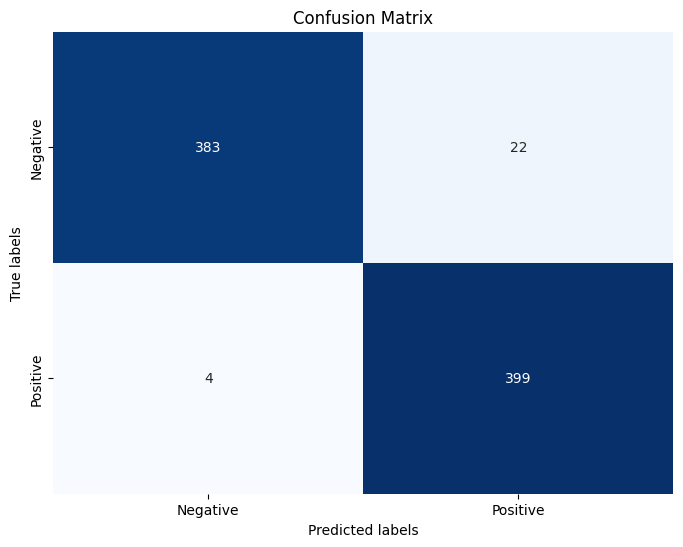

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False,xticklabels=["Negative","Positive"],yticklabels=["Negative","Positive"])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [4]:
import plotly.graph_objects as go

# Counts
positive_count = 2010
negative_count = 2029

# Calculate percentages
total_count = positive_count + negative_count
positive_percentage = (positive_count / total_count) * 100
negative_percentage = (negative_count / total_count) * 100

# Create labels and values
labels = ['Positive', 'Negative']
values = [positive_percentage, negative_percentage]

# Create pie chart
fig = go.Figure(data=[go.Pie(labels=labels, values=values)])

# Update layout
fig.update_layout(title='Distribution of Labels',
                  showlegend=True)

# Show the plot
fig.show()
